In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:

class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    y_pred = torch.nn.functional.log_softmax(y_pred, dim=1)
    return y_pred


In [5]:
train_loader.dataset.data.shape
train_loader.dataset.targets.shape

torch.Size([60000])

In [6]:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 784, 100, 10

# Create random Tensors to hold inputs and outputs
x_train = train_loader.dataset.data
y_train = train_loader.dataset.targets.float()

x_train = torch.flatten(x_train, start_dim=1, end_dim=2).float()

x_test = test_loader.dataset.data
y_test = test_loader.dataset.targets.float()

x_test = torch.flatten(x_test, start_dim=1, end_dim=2).float()

In [7]:
RUN_ON_GPU = True

model = TwoLayerNet(D_in, H, D_out)
loss_fn = torch.functional.F.nll_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

if RUN_ON_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
  print('Using GPU')
else:
  device = torch.device('cpu')
  print('Using CPU')

model.to(device)

loss_array = []

print("Size of x_train in MiB:", x_train.element_size() * x_train.nelement() / 1024**2)
print("Size of y_train in MiB:", y_train.element_size() * y_train.nelement() / 1024**2)

for t in range(50):

  x_train = x_train.to(device)
  y_train = y_train.to(device)

  # Forward pass: Compute predicted y by passing x to the model
  y_pred = model(x_train.float())

  # Compute and print loss
  loss = loss_fn(y_pred, y_train.long())

  loss_array.append(loss.item())

  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Using CPU
Size of x_train in MiB: 179.443359375
Size of y_train in MiB: 0.2288818359375


# Trainingszeiten

CPU: 6.4 s, 4 s, 3.9 s

GPU: 0.4 s, 0.5 s 0.4s

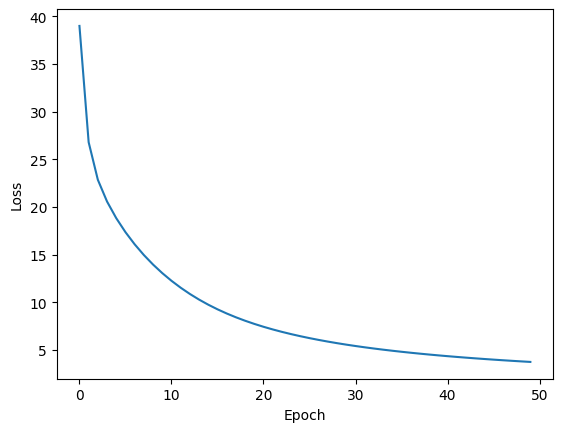

In [8]:
plt.plot(loss_array)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
true_guesses = 0

for test_point, test_label in zip(x_test, y_test):
  test_point = test_point.view(1, -1) # Reshape to 1x784, to match training data
  y_pred = model(test_point)
  if torch.argmax(y_pred) == test_label:
    true_guesses += 1

accuracy = true_guesses / len(y_test)
print("Accuracy:\t", accuracy * 100, "%")
print("Loss:\t\t", loss_array[-1])

Accuracy:	 59.56 %
Loss:		 3.7304470539093018
